In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### data

In [2]:
dfs = {}
for fname in os.listdir('./results/'):
    dfs[fname.replace('.csv', '')] = pd.read_csv(os.path.join('./results/', fname), index_col=0)

#### functions

In [3]:
def calc_metric(tp, tn, fp, fn, name):
    if name == 'accuracy':
        metric = (tp + tn) / sum([tp, tn, fp, fn])
    elif name == 'recall':
        metric = tp / (tp + fn)
    elif name == 'precision':
        metric = tp / (tp + fp)
    elif name == 'specificity':
        metric = tn / (tn + fp)
    elif name == 'npv':
        metric = tn / (tn + fn)
    elif name == 'f1':
        metric = tp / (tp + (.5 * (fp + fn)))
    return metric

In [4]:
def find_k(like, d):
    if isinstance(like, list):
        cols = []
        for i in d:
            if all([l.lower() in i.lower() for l in like]):
                cols.append(i)
    elif isinstance(like, str):
        cols = [i for i in d if like.lower() in i.lower()]
    return cols

In [5]:
def graph_nn_results(dfs, fnames, metric, name, tech_map):
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f'{name} NN Results', fontsize=16)
    techs = [fname.split('_')[0] for fname in fnames['size']]
    
    for tech in techs:
        fname = [fname for fname in fnames['size'] if tech in fname][0]
        df = dfs[fname]
        label = tech_map[fname.split('_')[0]]
        for pred_type in ['train', 'val']:
            scores = calc_metric(
                df[f'{pred_type}_tp'],
                df[f'{pred_type}_tn'],
                df[f'{pred_type}_fp'],
                df[f'{pred_type}_fn'],
                metric
            )
            mean_scores = scores.groupby(df['percent']).mean()
            if pred_type == 'train':
                p = ax[0].plot(mean_scores.index, mean_scores.values, linestyle='--')
                color = p[0].get_color()
            else:
                ax[0].plot(mean_scores.index, mean_scores.values, color=color, label=label, linestyle='-')
    ax[0].set_ylabel(metric.title())
    ax[0].set_xlabel('Training Size')
    ax[0].set_xticklabels([f'{int(p*100)}%' for p in ax[0].get_xticks()])
    
    for i, tech in enumerate(techs):
        fname = [fname for fname in fnames['iter'] if tech in fname][0]
        df = dfs[fname]
        label = tech_map[fname.split('_')[0]]
        for label, pred_type in zip(['Train', 'Validation'], ['train', 'val']):
            scores = calc_metric(
                df[f'{pred_type}_tp'],
                df[f'{pred_type}_tn'],
                df[f'{pred_type}_fp'],
                df[f'{pred_type}_fn'],
                metric
            )
            if i != 0:
                label = None
            if pred_type == 'train':
                p = ax[1].plot(df['iteration'], scores.values, label=label, linestyle='--')
                color = p[0].get_color()
            else:
                ax[1].plot(df['iteration'], scores.values, color=color, label=label, linestyle='-')
    ax[1].set_ylabel(metric.title())
    ax[1].set_xlabel('Iteration')
    ax[1].set_xscale('log')
    
    ax_twin = ax[2].twinx()
    df = dfs[fnames['final'][0]]
    df = df.set_index('technique')
    n = df.dropna().shape[0]
    for i, tech in enumerate(techs):
        y1 = df.loc[tech, metric]
        y2 = df.loc[tech, 'train_time']
        w = .15
        x = (n/2 * w) - (w * i) - (w / 2)
        p = ax[2].bar([x], y1, width=w)
        color = p[0].get_facecolor()
        x += 1
        ax_twin.bar([x], y2, color=color, width=w)
    ax[2].set_xticks(range(2))
    ax[2].set_xticklabels([metric.title(), 'Time'])
    ax[2].set_ylabel(metric.title())
    ax_twin.set_ylabel('Time')

    leg1 = plt.legend(*ax[0].get_legend_handles_labels(), bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.gca().add_artist(leg1)
    leg2 = plt.legend(*ax[1].get_legend_handles_labels(), bbox_to_anchor=(1.1, 0), loc='lower left')
    [handle.set_color('black') for handle in leg2.legendHandles]
    plt.gca().add_artist(leg2)
    plt.show()

In [6]:
def graph_cluster_choice(dfs, fnames, name, tech_map):
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plt.subplots_adjust(wspace=0.3)
    title = 'Choosing K Clusters'
    if name is not None:
        title = name + ' ' + title
    fig.suptitle(title, fontsize=16)
    ax_twin0 = ax[0].twinx()
    ax_twin1 = ax[1].twinx()
    
    plots = []
    plot_labels = []
    for fname in fnames:
        if 'spam' in fname:
            continue
        if 'em' in fname:
            a = ax_twin0
            c = 'tab:blue'
        else:
            a = ax[0]
            c = 'tab:orange'
        df = dfs[fname]
        label = tech_map[fname.split('_')[0]]
        p = a.plot(df.T.index, df.T.values, color=c)
        plots.append(p[0])
        plot_labels.append(label)
        
    for fname in fnames:
        if 'census' in fname:
            continue
        if 'em' in fname:
            a = ax_twin1
            c = 'tab:blue'
        else:
            a = ax[1]
            c = 'tab:orange'
        df = dfs[fname]
        label = tech_map[fname.split('_')[0]].replace(' ', '\n')
        a.plot(df.T.index, df.T.values, color=c)
    
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Silhouette')
    ax_twin0.set_ylabel('Log Likelihood')
    ax[0].set_title('Census')
    
    ax[1].set_xlabel('K')
    ax[1].set_ylabel('Silhouette')
    ax_twin1.set_ylabel('Log Likelihood')
    ax[1].set_title('Spam')
    
    plt.legend(plots, plot_labels, loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.show()

In [7]:
def graph_cluster_evaluate(dfs, fnames, name, tech_map):
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    plt.subplots_adjust(wspace=0.3)
    title = 'Cluster Evaluation'
    if name is not None:
        title = name + ' ' + title
    fig.suptitle(title, fontsize=16)
    
    fnames = sorted(fnames)
    datasets = np.unique([i.split('_')[1] for i in fnames])
    methods = np.unique([i.split('_')[0] for i in fnames])
    
    for i, metric in enumerate(['k', 'silhouette', 'information_gain']):
        x = np.arange(len(datasets))
        w = .35
        n = len(methods)
        plots = []
        plot_labels = []
        for j, method in enumerate(methods):
            y = []
            for fname in fnames:
                f_method = fname.split('_')[0]
                if f_method != method:
                    continue
                val = dfs[fname][metric].values[0]
                y.append(val)
            bump = (n/2 * w) - (w * j) - (w / 2)
            p = ax[i].bar(x + bump, y, width=w)
            plots.append(p)
            plot_labels.append(tech_map[method])
        ax[i].set_xticks(x)
        ax[i].set_xticklabels([i.title() for i in datasets])
        ax[i].set_title(metric.replace('_', ' ').title())

    plt.legend(plots, plot_labels, loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.show()

In [8]:
def graph_dr_choice(dfs, fnames, name, tech_map):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 5))
    plt.subplots_adjust(wspace=0.3)
    title = 'Choosing K Features'
    if name is not None:
        title = name + ' ' + title
    fig.suptitle(title, fontsize=16)

    methods = np.unique([i.split('_')[2] for i in fnames])
    datasets = np.unique([i.split('_')[1] for i in fnames])
    
    metric_map = {
        'pca': 'Explained Variance Ratio',
        'ica': 'Kurtosis',
        'rp': 'Reconstruction Error',
        'rf': 'Feature Importance'
    }
    for i, method in enumerate(methods):
        rel_fnames = [i for i in sorted(fnames) if method in i]
        plots = []
        plot_labels = []
        for fname in rel_fnames:
            df = dfs[fname]
            p = ax[i].plot(df.iloc[:, 0])
            plots.append(p[0])
            label = fname.split('_')[1].title()
            plot_labels.append(label)
        method = ''.join([i[0] if method.count(' ') > 0 else i for i in method.split(' ')])
        ax[i].set_xlabel('K')
        ylabel = metric_map[method]
        ax[i].set_ylabel(ylabel)
        title = tech_map.get(method, method.title())
        ax[i].set_title(title)
    
    plt.legend(plots, plot_labels, loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

In [9]:
def graph_dr_evaluate(dfs, fnames, name, tech_map):
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plt.subplots_adjust(wspace=0.3)
    title = 'Dimensionality Reduction Evaluation'
    if name is not None:
        title = name + ' ' + title
    fig.suptitle(title, fontsize=16)
    
    fnames = sorted(fnames)
    datasets = np.unique([i.split('_')[1] for i in fnames])
    methods = dfs[fnames[0]].index.tolist()
    
    for i, metric in enumerate(['k', 'reconstruction_error']):
        x = np.arange(len(datasets))
        w = .15
        n = len(methods)
        plots = []
        plot_labels = []
        for j, method in enumerate(methods):
            y = []
            for fname in fnames:
                val = dfs[fname].loc[method, metric]
                y.append(val)
            bump = (n/2 * w) - (w * j) - (w / 2)
            p = ax[i].bar(x + bump, y, width=w)
            plots.append(p)
            plot_labels.append(tech_map.get(method, method.title()))
        ax[i].set_xticks(x)
        ax[i].set_xticklabels([i.title() for i in datasets])
        ax[i].set_title(metric.replace('_', ' ').title())

    plt.legend(plots, plot_labels, loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.show()

In [10]:
tech_map = {
    'em': 'Expectation Maximization',
    'km': 'K-Means',
    'nn': 'Neural Network',
    'pca': 'PCA',
    'ica': 'ICA',
    'rp': 'Randomized Projection',
    'rf': 'Random Forest',
    'none': 'None'
}

#### clustering

In [12]:
dfs['km_spam']['2'].value_counts(normalize=True)

1    0.992663
0    0.007337
Name: 2, dtype: float64

In [13]:
f1 = [f for f in find_k(['census', 'log'], dfs) if f.count('_') == 3]
f2 = [f for f in find_k(['census', 'sil'], dfs) if f.count('_') == 2]
f3 = [f for f in find_k(['spam', 'log'], dfs) if f.count('_') == 3]
f4 = [f for f in find_k(['spam', 'sil'], dfs) if f.count('_') == 2]
files = set(f1).union(f2).union(f3).union(f4)

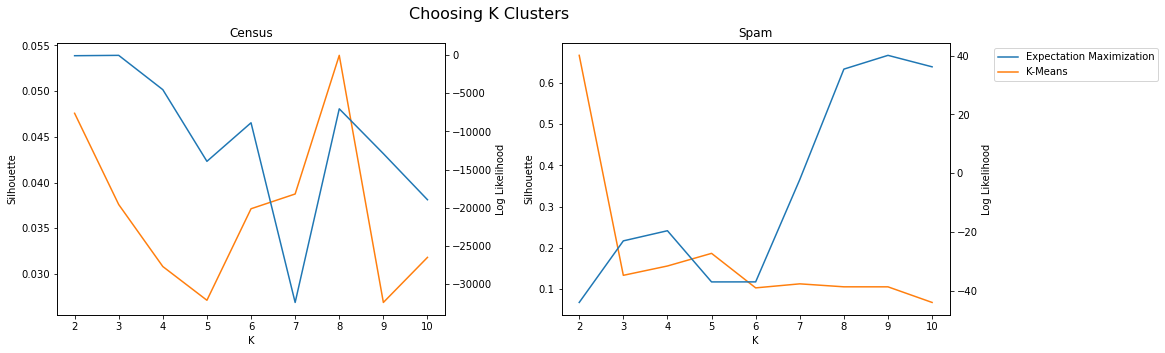

In [14]:
graph_cluster_choice(dfs, files, None, tech_map)

In [15]:
f1 = [i for i in find_k(['em', 'final'], dfs) if len(i.split('_')) == 3]
f2 = [i for i in find_k(['km', 'final'], dfs) if len(i.split('_')) == 3]
files = f1 + f2

In [16]:
kmap = {
    'km': {'spam': 5, 'census': 8},
    'em': {'spam': 8, 'census': 3}
}
for fname in files:
    method, dname, _ = fname.split('_')
    dfs[fname]['k'] = kmap[method][dname]

In [17]:
files

['em_census_final', 'em_spam_final', 'km_spam_final', 'km_census_final']

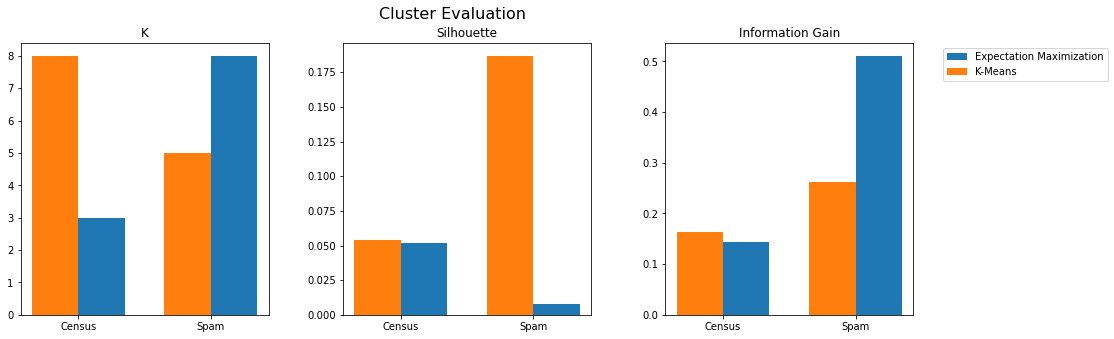

In [18]:
graph_cluster_evaluate(dfs, files, None, tech_map)

In [19]:
pd.concat([
    pd.concat([
        dfs['em_spam'].filter(like='8_').idxmax(axis=1).to_frame('8'),
        dfs['em_spam'][['label']]
    ], axis=1).groupby('8')['label'].mean(),
    dfs['em_spam'].filter(like='8_').idxmax(axis=1).to_frame('8').groupby('8').size()
], axis=1)

,label,0
8,,
8_0,0.304110,365
8_1,0.981818,110
8_2,0.889071,1217
8_3,0.145055,455
8_4,0.049645,141
8_5,0.066197,710
8_6,0.047359,549
8_7,0.022556,133


In [20]:
pd.concat([
    dfs['km_spam'].groupby('5')['label'].mean(),
    dfs['km_spam'].groupby('5').size()
], axis=1)

,label,0
5,,
0,0.000000,37
1,0.000000,27
2,0.931983,691
3,0.019391,361
4,0.311622,2564


In [21]:
dfs['km_census']['label'].value_counts(normalize=True)

0    0.759175
1    0.240825
Name: label, dtype: float64

In [22]:
dfs['em_spam']['label'].value_counts(normalize=True)

0    0.605978
1    0.394022
Name: label, dtype: float64

#### dimensionality reduction

In [25]:
files = [i for i in find_k(['dr'], dfs) if len(i.split('_')) > 2 and i.startswith('dr')]

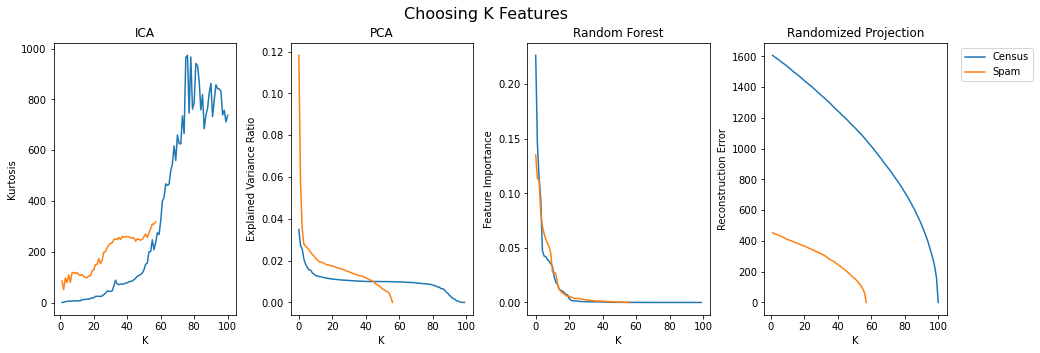

In [26]:
graph_dr_choice(dfs, files, None, tech_map)

In [28]:
files = [i for i in find_k(['dr'], dfs) if len(i.split('_')) == 2]

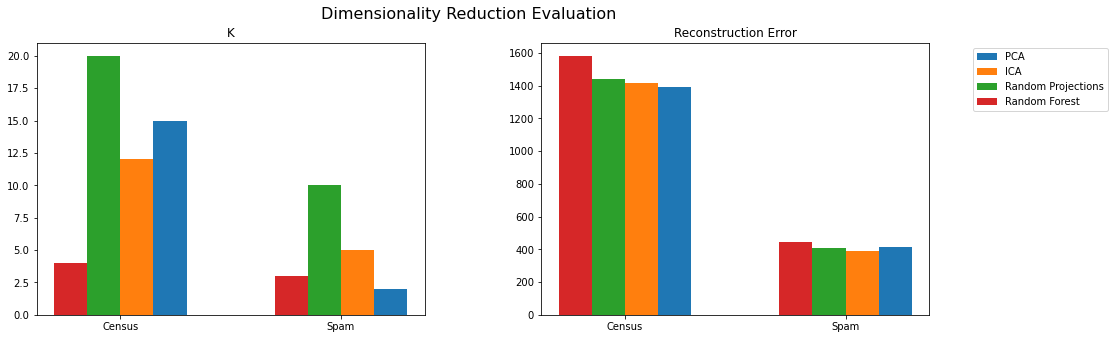

In [29]:
graph_dr_evaluate(dfs, files, None, tech_map)

#### clustering w/ dimensionality reduction

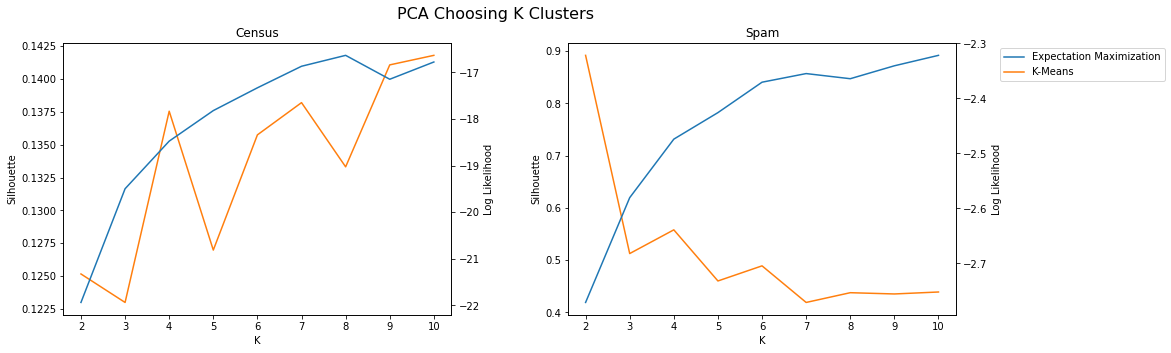

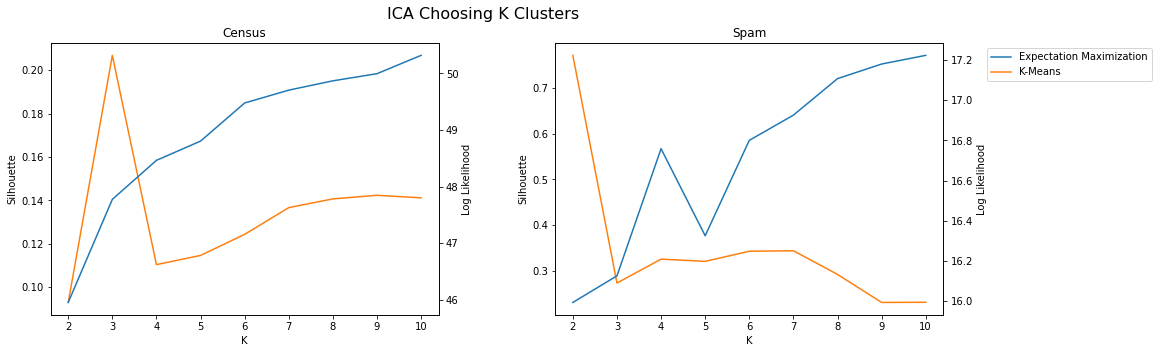

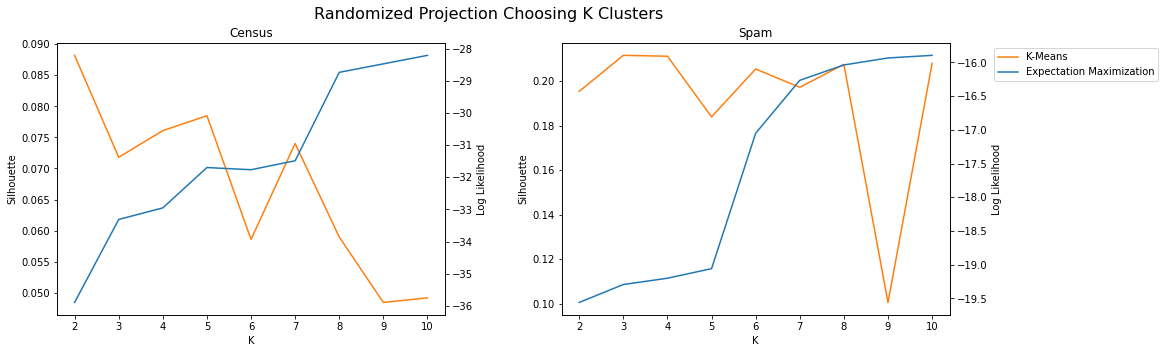

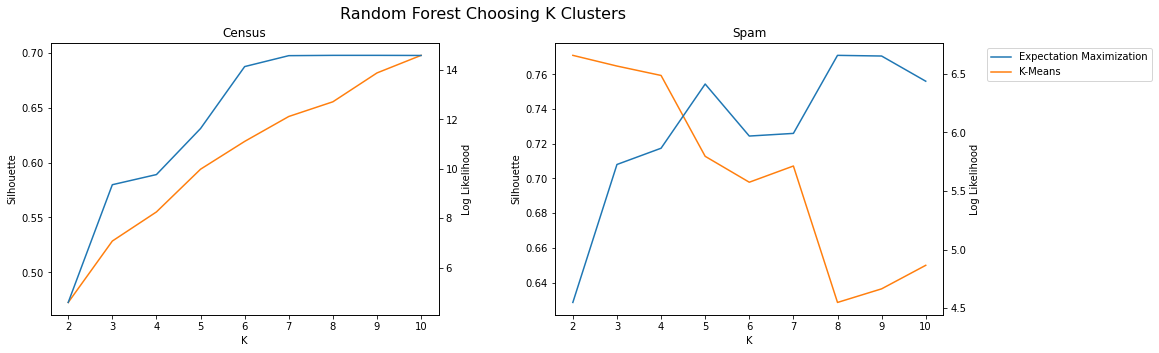

In [31]:
for method in ['pca', 'ica', 'rp', 'rf']:
    f1 = [f for f in find_k(['census', 'log', method], dfs)]
    f2 = [f for f in find_k(['census', 'sil', method], dfs)]
    f3 = [f for f in find_k(['spam', 'log', method], dfs)]
    f4 = [f for f in find_k(['spam', 'sil', method], dfs)]
    files = set(f1).union(f2).union(f3).union(f4)
    method = tech_map[method]
    graph_cluster_choice(dfs, files, method, tech_map)

In [33]:
kmap = {
    'pca': {'km': {'spam': 4, 'census': 4}, 'em': {'spam': 6, 'census': 8}},
    'ica': {'km': {'spam': 4, 'census': 4}, 'em': {'spam': 4, 'census': 4}},
    'rp': {'km': {'spam': 3, 'census': 2}, 'em': {'spam': 6, 'census': 8}},
    'rf': {'km': {'spam': 2, 'census': 5}, 'em': {'spam': 5, 'census': 6}},
}

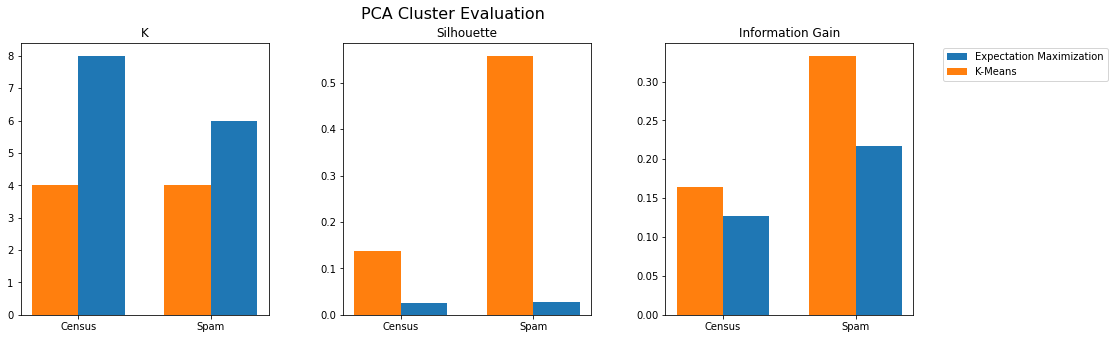

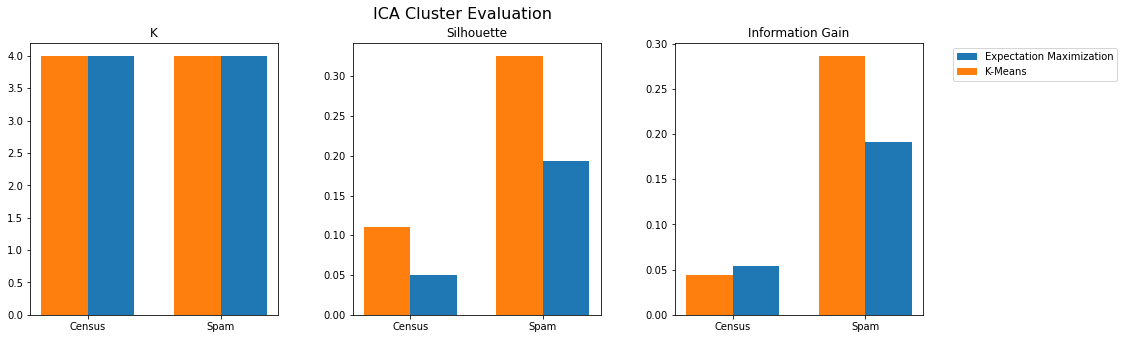

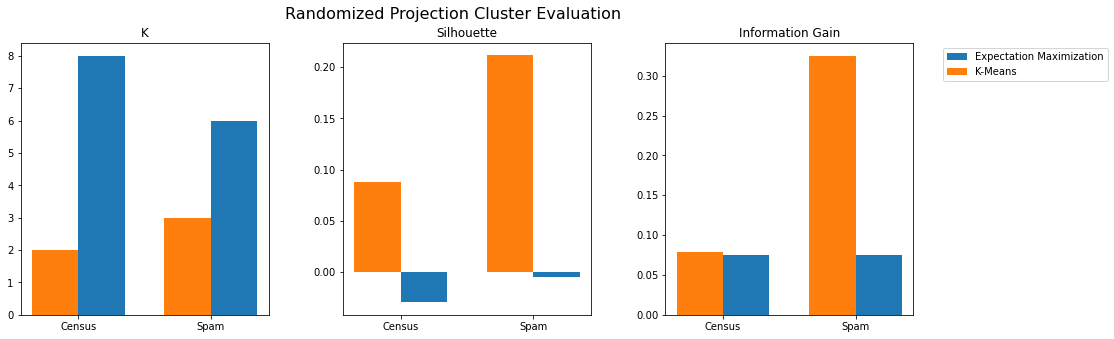

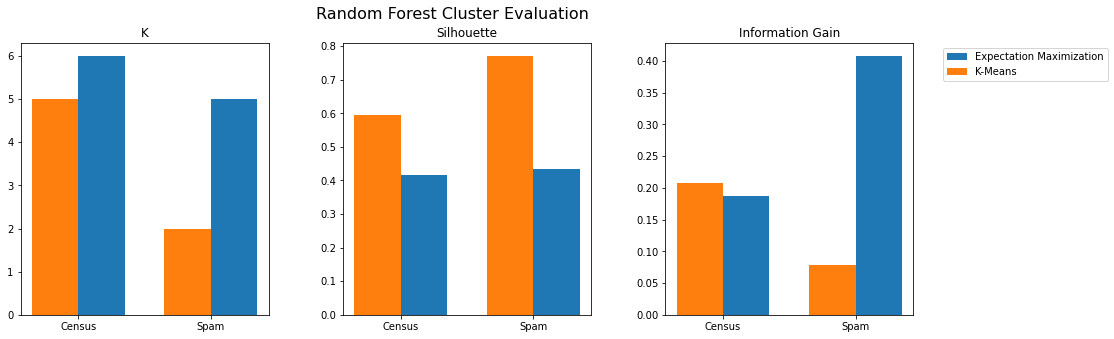

In [34]:
for dr_method in ['pca', 'ica', 'rp', 'rf']:
    f1 = [f for f in find_k(['final', 'em', dr_method], dfs)]
    f2 = [f for f in find_k(['final', 'km', dr_method], dfs)]
    files = f1 + f2
    for fname in files:
        c_method, dname, _, _ = fname.split('_')
        dfs[fname]['k'] = kmap[dr_method][c_method][dname]
    dr_method = tech_map[dr_method]
    graph_cluster_evaluate(dfs, files, dr_method, tech_map)

#### NN dimensionality reduction results

In [35]:
files = {
    'size': ['none_nn_size', 'pca_nn_size', 'ica_nn_size', 'rp_nn_size', 'rf_nn_size'],
    'iter': ['none_nn_iter', 'pca_nn_iter', 'ica_nn_iter', 'rp_nn_iter', 'rf_nn_iter'],
    'final': ['final_nn_dr_testing']
}

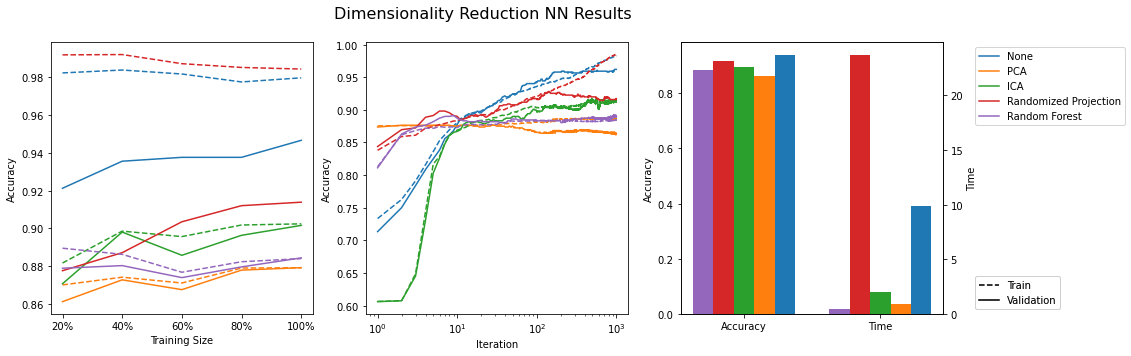

In [36]:
graph_nn_results(dfs, files, 'accuracy', 'Dimensionality Reduction', tech_map)

#### NN clustering results

In [37]:
files = {
    'size': ['none_nn_size', 'em_nn_size', 'km_nn_size'],
    'iter': ['none_nn_iter', 'em_nn_iter', 'km_nn_iter'],
    'final': ['final_nn_cluster_testing']
}

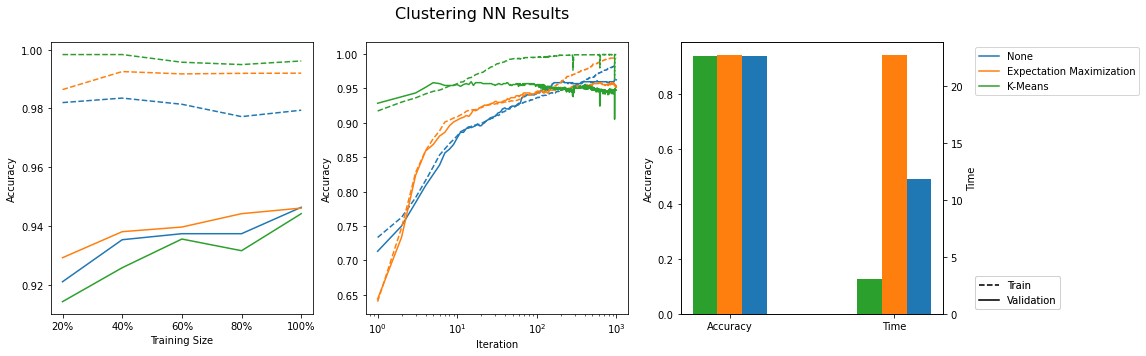

In [38]:
graph_nn_results(dfs, files, 'accuracy', 'Clustering', tech_map)